In [2]:
#hide
from utils import *

# Collaborative Filtering Deep Dive

## A First Look at the Data

In [3]:
from fastai2.collab import *
from fastai2.tabular.all import *
path = untar_data(URLs.ML_100k)

In [4]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.sample(10)

,user,movie,rating,timestamp
75721,877,381,4,882677345
80184,815,602,3,878694269
19864,94,431,4,891721716
76699,416,875,2,876696938
92991,500,182,2,883873556
76434,259,1074,3,874725264
84004,598,286,5,886711452
80917,886,496,4,876031952
60767,837,15,3,875721869
50074,521,184,4,884478358


## Learning the Latent Factors

## Creating the DataLoaders

In [5]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.sample(5)

,movie,title
1595,1596,Nemesis 2: Nebula (1995)
795,796,Speechless (1994)
203,204,Back to the Future (1985)
1127,1128,Heidi Fleiss: Hollywood Madam (1995)
1119,1120,I'm Not Rappaport (1996)


In [6]:
ratings = ratings.merge(movies)
ratings.sample(10)

,user,movie,rating,timestamp,title
70710,405,213,2,885549309,"Room with a View, A (1986)"
94554,299,19,1,877877434,Antonia's Line (1995)
8931,567,679,4,882426055,Conan the Barbarian (1981)
49082,401,404,2,891033395,Pinocchio (1940)
27447,128,483,5,879966785,Casablanca (1942)
59676,87,692,5,879876565,"American President, The (1995)"
50372,794,475,5,891035822,Trainspotting (1996)
31243,204,318,5,892513819,Schindler's List (1993)
74056,472,43,4,875982560,Disclosure (1994)
56136,907,121,4,880159015,Independence Day (ID4) (1996)


In [7]:
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [8]:
CollabDataLoaders??

In [9]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=32)
dls.show_batch()

,user,title,rating
0,721,In the Company of Men (1997),3
1,422,"American Werewolf in London, An (1981)",3
2,393,Timecop (1994),3
3,926,L.A. Confidential (1997),4
4,213,"Omen, The (1976)",4
5,13,Rosencrantz and Guildenstern Are Dead (1990),5
6,727,Demolition Man (1993),3
7,477,Broken Arrow (1996),4
8,59,Secrets & Lies (1996),4
9,224,Batman (1989),4


In [10]:
dls.classes

{'user': (#944) ['#na#',1,2,3,4,5,6,7,8,9...],
 'title': (#1665) ['#na#',"'Til There Was You (1997)",'1-900 (1994)','101 Dalmatians (1996)','12 Angry Men (1957)','187 (1997)','2 Days in the Valley (1996)','20,000 Leagues Under the Sea (1954)','2001: A Space Odyssey (1968)','3 Ninjas: High Noon At Mega Mountain (1998)'...]}

In [11]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [12]:
one_hot_3 = one_hot(3, n_users).float()

one_hot_3[:5]

tensor([0., 0., 0., 1., 0.])

In [13]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [14]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

## Collaborative Filtering from Scratch

In [15]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [16]:
x,y = dls.one_batch()
x.shape

torch.Size([32, 2])

In [17]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [18]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.263840,1.306186,00:17
1,1.166008,1.155984,00:17
2,0.985571,1.014012,00:17
3,0.809096,0.897295,00:17
4,0.798653,0.876842,00:17


In [19]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [20]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.978609,1.018570,00:17
1,0.866608,0.946230,00:17
2,0.698290,0.908106,00:17
3,0.458663,0.915006,00:17
4,0.307240,0.920003,00:17


In [21]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [22]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.943479,0.949309,00:19
1,0.824047,0.887194,00:19
2,0.610636,0.899981,00:19
3,0.399660,0.926807,00:19
4,0.268835,0.934550,00:19


### Weight Decay

In [23]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.922393,0.974032,00:19
1,0.879723,0.913127,00:19
2,0.831664,0.855579,00:19
3,0.667684,0.825327,00:19
4,0.567555,0.825145,00:19


### Creating Our Own Embedding Module

In [24]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [25]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [26]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.979427,0.963728,00:20
1,0.842604,0.898897,00:20
2,0.791573,0.851196,00:20
3,0.661636,0.827722,00:20
4,0.536017,0.825381,00:20


## Interpreting Embeddings and Biases

In [36]:
movie_bias = learn.model.movie_bias
print(movie_bias[:5])
movie_bias = movie_bias.squeeze()
print(movie_bias[:5])
print(movie_bias.sort()[:5])
idxs = movie_bias.argsort()[:5]
print(idxs)
[dls.classes['title'][i] for i in idxs]

tensor([-1.0825e-04, -6.7216e-02, -7.5717e-03, -1.2479e-02,  3.8339e-01], device='cuda:0', grad_fn=<SliceBackward>)
tensor([-1.0825e-04, -6.7216e-02, -7.5717e-03, -1.2479e-02,  3.8339e-01], device='cuda:0', grad_fn=<SliceBackward>)
(tensor([-0.2871, -0.2752, -0.2418,  ...,  0.5438,  0.5564,  0.5679], device='cuda:0', grad_fn=<SortBackward>), tensor([ 295,  850,  140,  ..., 1282,  830, 1501], device='cuda:0'))
tensor([ 295,  850,  140, 1001,  357], device='cuda:0')


['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Beautician and the Beast, The (1997)',
 'Mortal Kombat: Annihilation (1997)',
 'Crow: City of Angels, The (1996)']

In [37]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)']

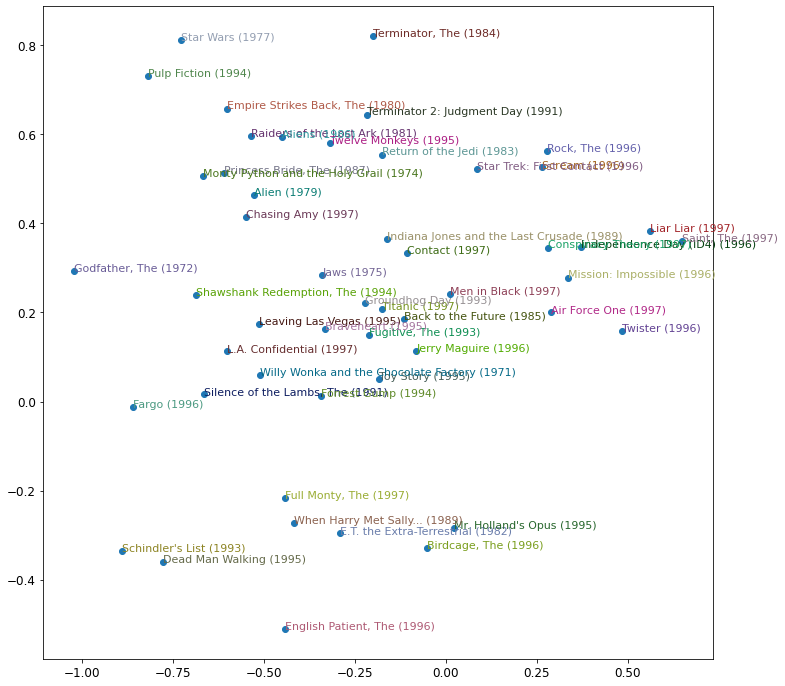

In [39]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Using fastai.collab

In [40]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [41]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.938180,0.970320,00:19
1,0.873645,0.908439,00:19
2,0.797199,0.860810,00:19
3,0.660767,0.829678,00:19
4,0.585688,0.827404,00:19


In [42]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [43]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Star Wars (1977)',
 'Titanic (1997)',
 'Silence of the Lambs, The (1991)']

### Embedding Distance

In [44]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Sling Blade (1996)'

## Deep Learning for Collaborative Filtering

In [45]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [46]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [47]:
model = CollabNN(*embs)

In [48]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.945698,0.952040,00:20
1,0.873725,0.918410,00:20
2,0.855510,0.891109,00:20
3,0.861010,0.876370,00:20
4,0.771665,0.878124,00:20


In [49]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.995804,0.979569,00:24
1,0.933367,0.933288,00:24
2,0.934717,0.905349,00:24
3,0.834169,0.881617,00:24
4,0.772533,0.873186,00:24
